<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**
https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

# **Setting**

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [3]:
#change with your path
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/CA/'

In [4]:
data = pd.read_table('https://liangfgithub.github.io/Data/faithful.dat', sep="\s+", index_col=0)

Text(0, 0.5, 'Waiting')

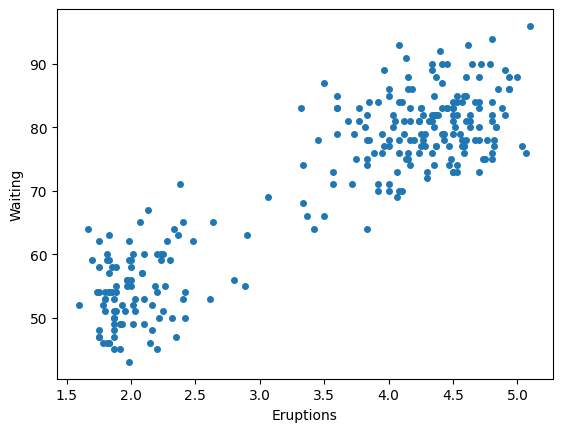

In [5]:
#create a pic for dataset
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

In [6]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


In [7]:
#create a matrix for all sample sizes for G, the corresponding p, u
def create_s_mtrx(G,n,s_interval=10): #sample size interval is default to 10, not required by instruction, but will need to handle G >2 as required by the instruction
  #matrix of G/ aka Z
  G_mtrx = np.arange(1,G+1,1)
  #sample size by group
  s_mtrx = s_interval*2**(G_mtrx-1)

  cumsum_s_mtrx =  np.cumsum(s_mtrx, axis =0)
  cumsum_s_mtrx

  #anything above limit taking 0s
  G_mtrx[cumsum_s_mtrx > n] = 0
  s_mtrx[cumsum_s_mtrx > n] = 0
  cumsum_s_mtrx[cumsum_s_mtrx > n] = 0
  #print(cumsum_s_mtrx)

  #biggest possible matrix
  max_G = np.where(cumsum_s_mtrx>0)[0][-1]+2

  final_G = min(max_G,G)
  last_s_mtrx = n - sum(s_mtrx[0:final_G-1])
  s_mtrx[final_G-1]=last_s_mtrx
  try:
    s_mtrx[final_G:]=0
  except:
    pass

  G_mtrx_final = np.arange(1,final_G+1,1)
  s_mtrx_final = s_mtrx[0:final_G]


  # initialize matrix of p
  p_mtrx = s_mtrx_final /n

  #create a new dim in data to show the G assignment
  G_assignment = np.repeat(G_mtrx_final,s_mtrx_final)
  p_assignment = np.repeat(p_mtrx,s_mtrx_final)

  #data with g assignment
  data_wg = data.copy()
  data_wg['G'] = G_assignment
  data_wg['p'] = p_assignment

  # calculate U by group for the two dimenison
  # keep column names so it's easier to understand
  mean_df = data_wg.groupby('G').mean().transpose()
  #u_by_k.columns = [ 'G','eruptions_avg',	'waiting_avg']

  return   G_mtrx_final, s_mtrx_final, p_mtrx, final_G, data_wg, mean_df


In [31]:
    p_mtrx[1]

0.9632352941176471

In [15]:
# a function to prepare a dataset with all columns ready
# for later calculation

def prep_data(G, G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df):

  #create a copy of data
  data_wg_cal = data_wg.copy()
  n = len(data_wg)

  #prepare mean/u for later processing
  mean_temp = mean_df.T

  # getting the initial p values
  print(mean_temp)
  p1 = mean_temp['p'].iloc[0]
  p2 = mean_temp['p'].iloc[1]
  if G==3:
    p3 = mean_temp['p'].iloc[2]

  mean_temp['ug'] = [np.array(row) for row in mean_temp[['eruptions','waiting']].to_numpy()]

  mean_mtrx_by_G = np.vstack(mean_temp['ug'].values)

  mean_mtrx = np.array(mean_df)
  data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
  data_erp = pd.DataFrame(data_erp)
  data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

  data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
  data_wait = pd.DataFrame(data_wait)
  data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

  data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
  data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

  data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
  data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

  data_p = pd.DataFrame(mean_mtrx[2]).transpose()
  data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

  data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
  data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)

  erp_mean=(s_mtrx*mean_mtrx[0]).sum()/n
  data_wg_cal['erp_mean'] = erp_mean
  data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
  wait_mean=(s_mtrx*mean_mtrx[1]).sum()/n
  data_wg_cal['wait_mean']= wait_mean
  data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']


  data_wg_cal['xi']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]
  data_wg_cal['u']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]
  data_wg_cal['u_1']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_1','wait_1']].to_numpy()]
  data_wg_cal['u_2']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_2','wait_2']].to_numpy()]
  if G==3:
    data_wg_cal['u_3']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_3','wait_3']].to_numpy()]

  data_wg_cal['xi_minus_u']= data_wg_cal['xi']-data_wg_cal['u']
  data_wg_cal['xi_minus_u1']= data_wg_cal['xi']-data_wg_cal['u_1']
  data_wg_cal['xi_minus_u2']= data_wg_cal['xi']-data_wg_cal['u_2']
  if G==3:
    data_wg_cal['xi_minus_u3']= data_wg_cal['xi']-data_wg_cal['u_3']

  data_wg_cal['xi_minus_u_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u']])
  data_wg_cal['xi_minus_u1_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_1']])
  data_wg_cal['xi_minus_u2_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_2']])
  if G==3:
    data_wg_cal['xi_minus_u3_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_3']])

  return data_wg_cal

In [17]:
#function to calculation sigma from the table
def calc_sigma(data_wg_cal):
  n=len(data_wg_cal)
  sigma = (data_wg_cal['xi_minus_u']*data_wg_cal['xi_minus_u_T']).sum(axis = 0)/n
  # find determinant of sigma |sigma|
  sigma_det = np.linalg.det(sigma)
  return sigma, sigma_det

In [36]:
def Estep(G, data_wg_cal, sigma, p_mtrx):
  n = len(data_wg_cal)
  data_wg_cal['sigma_inv'] =  [(sigma**-1)]*n

  sigma_det = np.linalg.det(sigma)
  #create log term
  # double check on the TA session @10/25/2024 with professor, and she allowed hard code G = 2 or 3
  # the second half of the log term is the probability density function (pdf) for 2D normal distribution
  # so this is basically calcating the sum of (probability * pdf), a.k.a: calculate the corresponding
  # distribution of Zi
  # the key term for prob density func pdf

  pdf_1  = -0.5* np.array(data_wg_cal['xi_minus_u1_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u1'].to_list())
  pdf_2  = -0.5* np.array(data_wg_cal['xi_minus_u2_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u2'].to_list())
  if G==3:
    pdf_3 = -0.5 * np.array(data_wg_cal['xi_minus_u3_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u3'].to_list())

  # this is the real pdf
  pdf_1_processed = p_mtrx[0]*np.exp(pdf_1)/(((2*np.pi)**2)*sigma_det)**0.5
  pdf_2_processed = p_mtrx[1]*np.exp(pdf_2)/(((2*np.pi)**2)*sigma_det)**0.5

  if G == 3:
    pdf_3_processed = p_mtrx[2]*np.exp(pdf_3)/(((2*np.pi)**2)*sigma_det)**0.5


  log_pdf_1_processed = np.log(pdf_1_processed)
  log_pdf_2_processed = np.log(pdf_2_processed)
  if G == 3:
    log_pdf_3_processed = np.log(pdf_3_processed)

  # Derivation 1:
  # compute the Marginal likelihood function
  # A marginal likelihood function (also known as the evidence in Bayesian statistics) is a probability function that represents the likelihood of
  # observing data under a specific model

  if G==2:
    loglik = np.log(pdf_1_processed+pdf_2_processed).sum(axis=0)
  else:
    loglik = np.log(pdf_1_processed+pdf_2_processed+pdf_3_processed).sum(axis=0)

  loglik = loglik.item() # change an array of shape (1,1) to 1 number,array([[-1552]]) -> 1522

  # Derivation 2:
  # compute the complete likelihood function
  # The complete likelihood (or complete-data likelihood) refers to the likelihood function that considers
  # both observed and unobserved (latent) data in a probabilistic model.

  if G==3:
    loglik_complete = log_pdf_1_processed + log_pdf_2_processed + log_pdf_3_processed
  else:
    loglik_complete = log_pdf_1_processed + log_pdf_2_processed

  loglik_complete = loglik_complete.sum()

  # Derivation 3:
  # create a matrix of weight, representing the weight of observation x1 assigned to Group G
  # Darin's answer on this post gives great explanation: https://campuswire.com/c/GB46E5679/feed/648

  try:
    w_i_1 = pdf_1_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)
    w_i_2 = pdf_2_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)
    w_i_3 = pdf_3_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)

  except:
    w_i_1 = pdf_1_processed / (pdf_1_processed + pdf_2_processed)
    w_i_2 = pdf_2_processed / (pdf_1_processed + pdf_2_processed)


  w_i_1 = np.squeeze(w_i_1).reshape(n,1)
  w_i_2 = np.squeeze(w_i_2).reshape(n,1)

  try:
    w_i_3 = np.squeeze(w_i_3).reshape(n,1)
  except:
    pass

  # output for Estep
  try:
    w_i_k = np.hstack((w_i_1,w_i_2,w_i_3))
  except:
    w_i_k = np.hstack((w_i_1,w_i_2))



  return w_i_k, loglik, loglik_complete

In [94]:
# this step should return the updated parameters for the Gaussian mixture model
def Mstep(G, data_wg_cal, sigma, w_i_k):
  n= len(data_wg_cal)
  p_mtrx = w_i_k.sum(axis = 0)/n

  erup_mean = (np.array(data_wg_cal['eruptions'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)/w_i_k.sum(axis = 0)
  wait_mean = (np.array(data_wg_cal['waiting'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)/w_i_k.sum(axis = 0)

  mean_df = pd.DataFrame(np.vstack((erup_mean,wait_mean,p_mtrx)))
  mean_df.index = ['eruptions', 'waiting', 'p']
  mean_df.columns = list(range(1,G+1))
  s_mtrx = w_i_k.sum(axis = 0)

  return p_mtrx, erup_mean, wait_mean, mean_df, s_mtrx

In [33]:
def myEM(data,G,itmax):
  #initilize dataset
  #sample size
  n=len(data)
  G=G

  G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df= create_s_mtrx(G,n,s_interval=10)
  data_wg_cal = prep_data(G, G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df)
  sigma, sigma_det = calc_sigma(data_wg_cal)
  w_i_k, loglik, loglik_complete  = Estep(G, data_wg_cal, sigma, p_mtrx)
  # report initial setting:
  print(f'initial setting: G= {final_G}, \n prob = {p_mtrx}, \n mean = \n{mean_df}, \n sigma = {sigma}, \n loglik = {loglik} \n ')
  i_loop = 1

  while itmax+1 > i_loop:


    p_mtrx, erup_mean, wait_mean, mean_df, s_mtrx = Mstep(G, data_wg_cal, sigma, w_i_k)
    #update dataset with output from Mstep
    data_wg = data_wg_cal[['eruptions', 'waiting', 'G', 'p']]
    #print(data_wg.columns.to_list())
    data_wg_cal = prep_data(G, G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df)
    w_i_k, loglik, loglik_complete  = Estep(G, data_wg_cal, sigma,p_mtrx)
    print(f'--------------------------------------------------------------')
    print(f'iteration = {i_loop}: \n prob = {p_mtrx}, \n mean = \n{mean_df}, \n sigma = \n{sigma}, \n loglik = {loglik} \n')

    i_loop = i_loop + 1




In [95]:
G=2

In [96]:
myEM(data,G,20)

   eruptions    waiting         p
G                                
1   3.303200  71.800000  0.036765
2   3.494828  70.862595  0.963235
initial setting: G= 2, 
 prob = [0.03676471 0.96323529], 
 mean = 
G                  1          2
eruptions   3.303200   3.494828
waiting    71.800000  70.862595
p           0.036765   0.963235, 
 sigma = [[  1.29793889  13.92641885]
 [ 13.92641885 184.14381488]], 
 loglik = -1561.625186289761 
 
   eruptions    waiting         p
1   3.263895  68.195294  0.037347
2   3.496469  71.001875  0.962653
--------------------------------------------------------------
iteration = 1: 
 prob = [0.03734675 0.96265325], 
 mean = 
                   1          2
eruptions   3.263895   3.496469
waiting    68.195294  71.001875
p           0.037347   0.962653, 
 sigma = 
[[  1.29793889  13.92641885]
 [ 13.92641885 184.14381488]], 
 loglik = -1558.7387549849766 

   eruptions    waiting         p
1   2.601016  60.246697  0.047417
2   3.531924  71.427208  0.952583
------

============================ CODE ARCHIVE ===================================

In [39]:
G_mtrx

array([1, 2])

In [40]:
s_mtrx

array([ 10, 262])

In [41]:
# https://liangfgithub.github.io/PSL/w7/w7_2_mixture.html
# Starting with an initial guess of our parameters, which encompass the means, variances, and mixing weight π of the Gaussians

p_mtrx

array([0.03676471, 0.96323529])

In [43]:
data_wg

,eruptions,waiting,G,p
1,3.600,79,1,0.036765
2,1.800,54,1,0.036765
3,3.333,74,1,0.036765
4,2.283,62,1,0.036765
5,4.533,85,1,0.036765
...,...,...,...,...
268,4.117,81,2,0.963235
269,2.150,46,2,0.963235
270,4.417,90,2,0.963235
271,1.817,46,2,0.963235


In [44]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [45]:
#create a copy of data for QA purpose
data_wg_cal = data_wg.copy()

In [46]:
#get mean by G
mean_df

G,1,2
eruptions,3.303200,3.494828
waiting,71.800000,70.862595
p,0.036765,0.963235


In [49]:
mean_temp = mean_df.T
mean_temp

,eruptions,waiting,p
G,,,
1,3.303200,71.800000,0.036765
2,3.494828,70.862595,0.963235


In [51]:
p1 = mean_temp['p'].iloc[0]
p2 = mean_temp['p'].iloc[1]
try:
  p3 = mean_temp['p'].iloc[2]
except:
  print('no G = 3')

no G = 3


In [52]:
mean_temp['ug'] = [np.array(row) for row in mean_temp[['eruptions','waiting']].to_numpy()]
mean_temp

,eruptions,waiting,p,ug
G,,,,
1,3.303200,71.800000,0.036765,"[3.3032000000000004, 71.8]"
2,3.494828,70.862595,0.963235,"[3.494828244274809, 70.86259541984732]"


In [53]:
mean_temp['ug'].to_numpy()

array([array([ 3.3032, 71.8   ]), array([ 3.49482824, 70.86259542])],
      dtype=object)

In [54]:
mean_mtrx_by_G = np.vstack(mean_temp['ug'].values)
mean_mtrx_by_G

array([[ 3.3032    , 71.8       ],
       [ 3.49482824, 70.86259542]])

In [55]:
for i in range(0,final_G):
  print(mean_mtrx_by_G[i])

[ 3.3032 71.8   ]
[ 3.49482824 70.86259542]


In [56]:
mean_mtrx = np.array(mean_df)

In [57]:

data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
data_erp = pd.DataFrame(data_erp)
data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [58]:
data_erp

,erp_diff_1,erp_diff_2
0,0.2968,0.105172
1,-1.5032,-1.694828
2,0.0298,-0.161828
3,-1.0202,-1.211828
4,1.2298,1.038172
...,...,...
267,0.8138,0.622172
268,-1.1532,-1.344828
269,1.1138,0.922172
270,-1.4862,-1.677828


In [59]:
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
data_wait = pd.DataFrame(data_wait)
data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [60]:
data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

In [61]:
data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

In [62]:
data_p = pd.DataFrame(mean_mtrx[2]).transpose()
data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

In [63]:


data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,erp_diff_1,erp_diff_2,wait_diff_1,wait_diff_2
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.2968,0.105172,7.2,8.137405
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.5032,-1.694828,-17.8,-16.862595
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.0298,-0.161828,2.2,3.137405
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.0202,-1.211828,-9.8,-8.862595
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.2298,1.038172,13.2,14.137405


In [64]:
data_wg_cal

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,erp_diff_1,erp_diff_2,wait_diff_1,wait_diff_2
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.2968,0.105172,7.2,8.137405
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.5032,-1.694828,-17.8,-16.862595
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.0298,-0.161828,2.2,3.137405
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.0202,-1.211828,-9.8,-8.862595
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.2298,1.038172,13.2,14.137405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,4.117,81,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.8138,0.622172,9.2,10.137405
268,2.150,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.1532,-1.344828,-25.8,-24.862595
269,4.417,90,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.1138,0.922172,18.2,19.137405
270,1.817,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.4862,-1.677828,-25.8,-24.862595


In [67]:
  erp_mean=(s_mtrx*mean_mtrx[0]).sum()/n
  data_wg_cal['erp_mean'] = erp_mean
  data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
  wait_mean=(s_mtrx*mean_mtrx[1]).sum()/n
  data_wg_cal['wait_mean']= wait_mean
  data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']


In [69]:
  data_wg_cal['xi']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]
  data_wg_cal['u']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]
  data_wg_cal['u_1']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_1','wait_1']].to_numpy()]
  data_wg_cal['u_2']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_2','wait_2']].to_numpy()]
  if G==3:
    data_wg_cal['u_3']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_3','wait_3']].to_numpy()]

In [70]:
data_wg_cal['xi_minus_u']= data_wg_cal['xi']-data_wg_cal['u']
data_wg_cal['xi_minus_u1']= data_wg_cal['xi']-data_wg_cal['u_1']
data_wg_cal['xi_minus_u2']= data_wg_cal['xi']-data_wg_cal['u_2']
try:
  data_wg_cal['xi_minus_u3']= data_wg_cal['xi']-data_wg_cal['u_3']
except:
  print('no G = 3')

no G = 3


In [71]:
data_wg_cal['xi_minus_u_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u']])
data_wg_cal['xi_minus_u1_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_1']])
data_wg_cal['xi_minus_u2_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_2']])
try:
  data_wg_cal['xi_minus_u3_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_3']])
except:
  print('no G = 3')

no G = 3


In [72]:
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,...,wait_diff,u,u_1,u_2,xi_minus_u,xi_minus_u1,xi_minus_u2,xi_minus_u_T,xi_minus_u1_T,xi_minus_u2_T
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,8.102941,"[[3.4877830882352936], [70.8970588235294]]","[[3.3032000000000004], [71.8]]","[[3.494828244274809], [70.86259541984732]]","[[0.1122169117647065], [8.102941176470594]]","[[0.29679999999999973], [7.200000000000003]]","[[0.10517175572519122], [8.137404580152676]]","[[0.1122169117647065, 8.102941176470594]]","[[0.29679999999999973, 7.200000000000003]]","[[0.10517175572519122, 8.137404580152676]]"
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-16.897059,"[[3.4877830882352936], [70.8970588235294]]","[[3.3032000000000004], [71.8]]","[[3.494828244274809], [70.86259541984732]]","[[-1.6877830882352935], [-16.897058823529406]]","[[-1.5032000000000003], [-17.799999999999997]]","[[-1.6948282442748088], [-16.862595419847324]]","[[-1.6877830882352935, -16.897058823529406]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.6948282442748088, -16.862595419847324]]"
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,3.102941,"[[3.4877830882352936], [70.8970588235294]]","[[3.3032000000000004], [71.8]]","[[3.494828244274809], [70.86259541984732]]","[[-0.1547830882352934], [3.102941176470594]]","[[0.029799999999999827], [2.200000000000003]]","[[-0.16182824427480869], [3.137404580152676]]","[[-0.1547830882352934, 3.102941176470594]]","[[0.029799999999999827, 2.200000000000003]]","[[-0.16182824427480869, 3.137404580152676]]"
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-8.897059,"[[3.4877830882352936], [70.8970588235294]]","[[3.3032000000000004], [71.8]]","[[3.494828244274809], [70.86259541984732]]","[[-1.2047830882352937], [-8.897058823529406]]","[[-1.0202000000000004], [-9.799999999999997]]","[[-1.211828244274809], [-8.862595419847324]]","[[-1.2047830882352937, -8.897058823529406]]","[[-1.0202000000000004, -9.799999999999997]]","[[-1.211828244274809, -8.862595419847324]]"
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,14.102941,"[[3.4877830882352936], [70.8970588235294]]","[[3.3032000000000004], [71.8]]","[[3.494828244274809], [70.86259541984732]]","[[1.0452169117647068], [14.102941176470594]]","[[1.2298], [13.200000000000003]]","[[1.0381717557251915], [14.137404580152676]]","[[1.0452169117647068, 14.102941176470594]]","[[1.2298, 13.200000000000003]]","[[1.0381717557251915, 14.137404580152676]]"


In [73]:

 #CA4,instruction p2, after 'Testing'
sigma = (data_wg_cal['xi_minus_u']*data_wg_cal['xi_minus_u_T']).sum(axis = 0)/n
sigma

array([[  1.29793889,  13.92641885],
       [ 13.92641885, 184.14381488]])

In [74]:
# find determinant of sigma |sigma|
sigma_det = np.linalg.det(sigma)
sigma_det

45.06227685606514

In [75]:
data_wg_cal['sigma_inv'] =  [(sigma**-1)]*n

In [76]:
#create log term
# double check on the TA session @10/25/2024 with professor, and she allowed hard code G = 2 or 3
# the second half of the log term is the probability density function (pdf) for 2D normal distribution
# so this is basically calcating the sum of (probability * pdf), a.k.a: calculate the corresponding
# distribution of Zi
# the key term for prob density func pdf

pdf_1  = -0.5* np.array(data_wg_cal['xi_minus_u1_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u1'].to_list())
pdf_2  = -0.5* np.array(data_wg_cal['xi_minus_u2_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u2'].to_list())
try:
  pdf_3 = -0.5 * np.array(data_wg_cal['xi_minus_u3_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u3'].to_list())
except:
  print('no G==3')

no G==3


In [77]:
pdf_1.shape

(272, 1, 1)

In [78]:
# this is the real pdf
pdf_1_processed = p1*np.exp(pdf_1)/(((2*np.pi)**2)*sigma_det)**0.5
pdf_2_processed = p2*np.exp(pdf_2)/(((2*np.pi)**2)*sigma_det)**0.5
try:
  pdf_3_processed = p3*np.exp(pdf_3)/(((2*np.pi)**2)*sigma_det)**0.5
except:
  print('no G==3')

no G==3


In [79]:
log_pdf_1_processed = np.log(pdf_1_processed)
log_pdf_2_processed = np.log(pdf_2_processed)
try:
  log_pdf_3_processed = np.log(pdf_3_processed)
except:
  print('no G==3')

no G==3


In [80]:
pdf_1_processed.shape
# n * little sigma

(272, 1, 1)

In [81]:
pdf_1_processed[0]

array([[0.00062782]])

E-Step
https://campuswire.com/c/GB46E5679/feed/589

In [82]:
# Derivation 1:
# compute the Marginal likelihood function
# A marginal likelihood function (also known as the evidence in Bayesian statistics) is a probability function that represents the likelihood of
# observing data under a specific model

if G==2:
  loglik = np.log(pdf_1_processed+pdf_2_processed).sum(axis=0)
else:
  loglik = np.log(pdf_1_processed+pdf_2_processed+pdf_3_processed).sum(axis=0)

loglik = loglik.item() # change an array of shape (1,1) to 1 number,array([[-1552]]) -> 1522
loglik


-1561.625186289761

In [83]:
# Derivation 2:
# compute the complete likelihood function
# The complete likelihood (or complete-data likelihood) refers to the likelihood function that considers
# both observed and unobserved (latent) data in a probabilistic model.

try:
  loglik_complete = log_pdf_1_processed + log_pdf_2_processed + log_pdf_1_processed
except:
  loglik_complete = log_pdf_1_processed + log_pdf_2_processed

loglik_complete = loglik_complete.sum()
loglik_complete

-6494.363907546027

In [84]:
# Derivation 3:
# create a matrix of weight, representing the weight of observation x1 assigned to Group G
# Darin's answer on this post gives great explanation: https://campuswire.com/c/GB46E5679/feed/648

try:
  w_i_1 = pdf_1_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)
  w_i_2 = pdf_2_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)
  w_i_3 = pdf_3_processed / (pdf_1_processed + pdf_2_processed + pdf_3_processed)

except:
  w_i_1 = pdf_1_processed / (pdf_1_processed + pdf_2_processed)
  w_i_2 = pdf_2_processed / (pdf_1_processed + pdf_2_processed)

In [85]:
w_i_1 = np.squeeze(w_i_1).reshape(n,1)
w_i_2 = np.squeeze(w_i_2).reshape(n,1)

try:
  w_i_3 = np.squeeze(w_i_3).reshape(n,1)
except:
  print('no G==3')

no G==3


In [86]:
# output for Estep
try:
  w_i_k = np.hstack((w_i_1,w_i_2,w_i_3))
except:
  w_i_k = np.hstack((w_i_1,w_i_2))

In [93]:
(np.array(data_wg_cal['eruptions'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)/w_i_k.sum(axis = 0)

array([3.26389547, 3.49646895])

In [87]:
w_i_k.sum() # return n * 100% = 272

272.0

In [88]:
# Derivation 3:
# create a matrix of weight, representing the weight of observation x1 assigned to Group G
# Darin's answer on this post gives great explanation: https://campuswire.com/c/GB46E5679/feed/648
# Mstep - maximize the probability of P given the observation
w_i_k.sum(axis = 0)/n
# iter 0-  array([0.03676471, 0.07352941, 0.88970588])

array([0.03734675, 0.96265325])

In [91]:
w_i_k.sum(axis = 0)

array([ 10.15831483, 261.84168517])

In [89]:
p_mtrx_new = w_i_k.sum(axis = 0)/n

In [90]:
p1_new = p_mtrx_new[0]
p2_new = p_mtrx_new[1]
p3_new = p_mtrx_new[2]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
#initial mean
mean_mtrx_by_G

In [ ]:
erup_mean_tmp = (np.array(data_wg_cal['eruptions'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)
wait_mean_tmp = (np.array(data_wg_cal['waiting'].to_list()).reshape((n,1))*w_i_k).sum(axis = 0)

In [ ]:
erup_mean_tmp

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm

# **================ CODE ARCHIVE ================================**

In [ ]:
# TEST PANDA WITH MATRIX
matrix_1 = pd.DataFrame([[1, 2], [3, 4]])

In [ ]:
matrix_1

In [ ]:
# TEST PANDA WITH MATRIX
matrix_2 = pd.DataFrame([[[1,2],[3, 4]], [[5, 6],[7,8]]])

In [ ]:
matrix_2

In [ ]:
matrix_3 = pd.DataFrame([[np.zeros((2,3))], [np.zeros((3,2))]])
matrix_3

In [ ]:
data_wg_cal.head()

In [ ]:
data_wg_cal['x_i']= [np.array(row) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]

In [ ]:
data_wg_cal['u_g']= [np.array(row) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [ ]:
data_wg_cal

In [ ]:
data_wg_cal['x_i'] - data_wg_cal['u_g']

In [ ]:

#silly way to calculate sigma - result match
# [a,b] * [a,b].T is bascially a^2 +ab+ab+ b^2
#data_wg_cal[['eruptions_2',	'waiting_2']] = data_wg_cal[[	'eruptions',	'waiting']]**2
#data_wg_cal[['erp_mean_2',	'wait_mean_2']] = data_wg_cal[[	'erp_mean',	'wait_mean']]**2
#data_wg_cal['eruptions_erp_mean'] = data_wg_cal['eruptions']*data_wg_cal['erp_mean']
#data_wg_cal['waiting_wait_mean'] = data_wg_cal['waiting']*data_wg_cal['wait_mean']
data_wg_cal[['erp_diff_2',	'wait_diff_2']]  = data_wg_cal[[	'erp_diff',	'wait_diff']]**2
data_wg_cal['erp_wait_diff']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']
data_wg_cal['erp_wait_diff_again']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']

#CA4,instruction p2, after 'Testing'
sigma = np.array(data_wg_cal[['erp_diff_2','erp_wait_diff','erp_wait_diff_again','wait_diff_2']].mean()).reshape(2,2)
sigma

In [ ]:
#manually check the determinant function
#det(A)=ad−bc
sigma_det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
sigma_det